In [93]:
import os
os.chdir('/content/drive/MyDrive/CAMemBERT2')
import glob
import json
import pdb
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
plt.ioff()

In [94]:
tasks = ['aes','ged','ner']
global tasks
best_metrics_for_task = {'aes':'pearson_aes','ged':'f_0_5_ged','ner':'f1_score_macro_ner'}
global best_metrics_for_task

def create_loss_plot(data,model):
    try:
        train_loss,train_steps,eval_loss,eval_steps = data['train']['loss'],data['train']['step'],data['eval']['total_loss'], data['eval']['step']
    except:
        print(f'missing loss data for {model}')
        return
    train_loss,train_steps,eval_loss,eval_steps = [[round(val, 1) for val in metric] for metric in [train_loss,train_steps,eval_loss,eval_steps]]
    fig= plt.figure()
    plt.plot(train_steps,train_loss,'r',label='train')
    plt.plot(eval_steps,eval_loss,'b',label='eval')
    plt.legend(loc="upper right")
    plt.title(f'Loss vs Steps : {model}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    fig.savefig(f'/content/drive/MyDrive/CAMemBERT2/results/plots/losses/{model.replace(".","")}')
    plt.close()

def create_test_pred_plot(data,model):
    try:
        preds,labels = data['preds'],data['labels']
    except:
        print(f'missing loss data for {model}')
        return
    preds,labels = [[round(val, 1) for val in metric] for metric in [preds,labels]]
    fig= plt.figure()
    plt.scatter(preds,labels)
    plt.title(f'Predicted vs Acutal Scores : {model}')
    plt.xlabel('Predicted Score')
    plt.ylabel('Acutal Score')
    plt.savefig(f'/content/drive/MyDrive/CAMemBERT2/results/plots/predictions/{model.replace(".","")}')
    plt.close()

def append_model_details(task_dict,set_type,task,model,data):
    task_dict[set_type][task]['model'].append(model)
    task_dict[set_type][task]['learning_rate'].append(data['info']['learning_rate'])
    task_dict[set_type][task]['batch_size'].append(data['info']['batch_size'])
    task_dict[set_type][task]['pretrained_model'].append(data['info']['pretrained_model'])
    task_dict[set_type][task]['frozen_layers'].append(data['info']['frozen_layers'])
    task_dict[set_type][task]['normalised_values'].append(data['info']['normalised_values'])
    task_dict[set_type][task]['epochs'].append(round(max(data['eval']['epoch'])))
    task_dict[set_type][task]['runtime'].append(data['info']['runtime'])
    task_dict[set_type][task]['secs_per_epoch'].append(data['info']['runtime']/len(data['eval']['epoch']))
    task_dict[set_type][task]['n_shared_layers'].append(data['info']['shared_encoder_n_layers'])
    task_dict[set_type][task]['position'].append(data['info']['output_layer_by_task'][task])
    task_dict[set_type][task]['task_priorites'].append(data['info']['task_priorities_priority_as_key'])
    task_dict[set_type][task]['init_task_weightings'].append(data['info']['init_task_weightings'])
    if task=='aes':
        task_dict[set_type][task]['scoring'].append(data['info']['scoring'])
    return task_dict

def update_task_dict(task,task_dict,data):
    [task_dict['eval'][task][metric_name].append(value) for metric_name,value in data['best'][task].items() if 'weight_coef' not in metric_name]
    task_dict = append_model_details(task_dict,'eval',task,model,data)
    test_metrics_for_task = {metric_name:value for metric_name,value in data['test'].items() if task in metric_name}
    [task_dict['test'][task][metric_name].append(value) for metric_name,value in test_metrics_for_task.items() if 'weight_coef' not in metric_name]
    task_dict = append_model_details(task_dict,'test',task,model,data)
    return task_dict

def create_result_csvs(task_dict):
    dfs_set_type = {}
    for set_type,dicts in task_dict.items():
        dfs_set_type[set_type] = {}
        for task,metrics in dicts.items():
            df = pd.DataFrame(metrics).sort_values(by = best_metrics_for_task[task],ascending=False)
            df['frozen_layers'] = df['frozen_layers'].fillna(0)
            print(set_type,task,'\n',df)
            df.to_csv(f'/content/drive/MyDrive/CAMemBERT2/results/{set_type}_results/{task}.csv')
            dfs_set_type[set_type][task] = df
    return dfs_set_type

task_dict = {'eval':defaultdict(lambda: defaultdict(list)),'test':defaultdict(lambda: defaultdict(list))}
for fp in glob.glob('/content/drive/MyDrive/CAMemBERT2/results/raw_results/*.json'):
    with open(fp) as json_file:
        data = json.load(json_file)
    model = fp.split('/')[-1].replace('.json','')
    create_loss_plot(data,model)
    try:
        data['preds']
        create_test_pred_plot(data['preds']['aes'],model)
    except:
        pass
    for task in tasks:
        if task in data['info']['tasks']:
            task_dict = update_task_dict(task,task_dict,data)

dfs = create_result_csvs(task_dict)


missing loss data for 1630760512
missing loss data for 1630763494
missing loss data for 1630763624
eval aes 
     rmse_aes  ...  scoring
0   6.191051  ...   script
3   5.741256  ...   script
12  7.338067  ...   script
1   4.297482  ...   script
4   4.297482  ...   script
10  6.191392  ...   script
27  4.284987  ...   script
8   5.385165  ...   script
25  4.344537  ...   script
26  4.366858  ...   script
2   4.911882  ...   script
5   4.911882  ...   script
17  5.271780  ...   script
28  5.591412  ...   script
18  6.239436  ...   script
23  5.416026  ...   script
15  5.246692  ...   script
24  4.615794  ...   script
14  5.844038  ...   script
21  4.630815  ...   script
7   5.651257  ...   script
13  5.921946  ...   script
19  6.848560  ...   script
22  4.668155  ...   script
16  4.759493  ...   script
11  5.596378  ...   script
20  6.094168  ...   script
6   5.245854  ...   script
9   6.653111  ...   script

[29 rows x 19 columns]
eval ged 
     accuracy_ged  ...                        

Text(0, 0.5, 'performance metric')

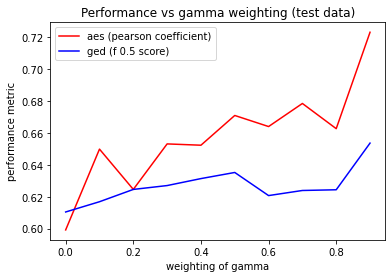

In [115]:
# dfaes = dfs['eval']['aes'].copy()
# dfged = dfs['eval']['ged'].copy()
# dfner = dfs['eval']['ner'].copy()
# dfaes['init_task_weightings'] = dfaes['init_task_weightings'].apply(lambda x : x['aes'])
# dfged['init_task_weightings'] = dfged['init_task_weightings'].apply(lambda x : x['ged'])

aes_values = dfaes.groupby('init_task_weightings')['pearson_aes'].max().values
ged_values = dfged.groupby('init_task_weightings')['f_0_5_ged'].max().values

plt.plot([x*0.1 for x in range(0,10)],aes_values,'r',label='aes (pearson coefficient)')
plt.plot([x*0.1 for x in range(0,10)], ged_values,'b',label='ged (f 0.5 score)')
plt.legend(loc="upper left")
plt.title(f'Performance vs gamma weighting (test data)')
plt.xlabel('weighting of gamma')
plt.ylabel('performance metric')


In [111]:
dfaes = dfs['eval']['aes'].copy()
dfged = dfs['eval']['ged'].copy()
dfner = dfs['eval']['ner'].copy()
dfaes['init_task_weightings'] = dfaes['init_task_weightings'].apply(lambda x : x['aes'])
dfged['init_task_weightings'] = dfged['init_task_weightings'].apply(lambda x : x['ged'])
dfner['init_task_weightings'] = dfaes['init_task_weightings'].apply(lambda x : x['ner'])


In [ ]:
dfaes.group.loc[]

In [117]:
dfs['eval']['aes']

,rmse_aes,pearson_aes,spearman_aes,kappa_aes,aes,model,learning_rate,batch_size,pretrained_model,frozen_layers,normalised_values,epochs,runtime,secs_per_epoch,n_shared_layers,position,task_priorites,init_task_weightings,scoring
0,6.191051,0.723195,0.709895,0.504012,0.026505,1630758066,0.00001,8,distilroberta-base,0.0,"[40, 0]",8,258.907881,32.363485,0,-1,{'primary_task': 'aes'},1.0,script
3,5.741256,0.699714,0.705288,0.530149,0.023281,1630758625,0.00001,8,distilroberta-base,3.0,"[40, 0]",8,259.094810,32.386851,0,-1,{'primary_task': 'aes'},1.0,script
12,7.338067,0.687928,0.689074,0.364470,0.007145,1630770086,0.00004,8,distilroberta-base,0.0,"[40, 0]",7,429.960674,61.422953,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...",1.0,script
1,4.297482,0.682024,0.672960,0.644156,0.012685,1630758199,0.00004,8,distilroberta-base,0.0,"[40, 0]",4,129.927766,32.481941,0,-1,{'primary_task': 'aes'},1.0,script
4,4.297482,0.682024,0.672960,0.644156,0.012685,1630758757,0.00004,8,distilroberta-base,3.0,"[40, 0]",4,129.999357,32.499839,0,-1,{'primary_task': 'aes'},1.0,script
10,6.191392,0.681187,0.690697,0.500315,0.005103,1630769421,0.00004,8,distilroberta-base,0.0,"[40, 0]",8,526.645727,65.830716,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...",1.0,script
27,4.284987,0.678513,0.645618,0.673079,0.001910,1630779563,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.141738,67.828348,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.8,script
8,5.385165,0.674753,0.687706,0.456649,0.020411,1630759194,0.00008,8,distilroberta-base,6.0,"[40, 0]",5,63.273350,12.654670,0,-1,{'primary_task': 'aes'},1.0,script
25,4.344537,0.670987,0.641220,0.635439,0.001473,1630778877,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.016226,67.803245,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.6,script
26,4.366858,0.664037,0.646414,0.628849,0.001755,1630779220,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.124227,67.824845,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.7,script


In [97]:
dfs['eval']['ner']

,accuracy_ner,f1_score_macro_ner,f1_score_weighted_ner,ner,model,learning_rate,batch_size,pretrained_model,frozen_layers,normalised_values,epochs,runtime,secs_per_epoch,n_shared_layers,position,task_priorites,init_task_weightings
18,0.992154,0.958175,0.992176,0.026681,1630771990,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,245.185335,40.864222,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
19,0.991842,0.955889,0.991851,0.028066,1630772236,0.00004,8,distilroberta-base,0.0,"[40, 0]",8,702.113476,87.764184,2,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
2,0.992309,0.954741,0.992315,0.035556,1630762602,0.00008,8,distilroberta-base,0.0,"[40, 0]",8,277.414044,34.676755,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
5,0.992309,0.954741,0.992315,0.035556,1630763444,0.00008,8,distilroberta-base,3.0,"[40, 0]",8,277.561677,34.695210,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
21,0.991667,0.954687,0.991613,0.026765,1630773694,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,270.488224,67.622056,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
4,0.991414,0.950570,0.991412,0.037134,1630763164,0.00004,8,distilroberta-base,3.0,"[40, 0]",8,277.592623,34.699078,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
1,0.991414,0.950570,0.991412,0.037134,1630762321,0.00004,8,distilroberta-base,0.0,"[40, 0]",8,277.315627,34.664453,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
17,0.991219,0.950100,0.991195,0.027494,1630771740,0.00004,8,distilroberta-base,0.0,"[40, 0]",7,231.220001,33.031429,0,4,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
12,0.991239,0.947999,0.991223,0.027239,1630770086,0.00004,8,distilroberta-base,0.0,"[40, 0]",7,429.960674,61.422953,0,4,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
14,0.990557,0.947436,0.990584,0.032562,1630770873,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,491.892654,81.982109,2,4,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}"
